### Plot of spice anomaly slopes for Dove et al 2021

In [2]:
import numpy as np
import xarray as xr 

import matplotlib.pylab as plt
from matplotlib.colors import BoundaryNorm
import glidertools as gt

from cmocean import cm as cmo

import gsw

In [3]:
plt.style.use('seaborn-colorblind')
plt.rcParams['font.size'] = 12

In [7]:
data_dir = '/Users/dhruvbalwada/OneDrive/sogos_data'
data_659 = data_dir+'/data/interim/gliders/sg659_20201010/CTD_659.nc'
data_660 = data_dir+'/data/interim/gliders/sg660_20201010/CTD_660.nc'

ds_659 = xr.load_dataset(data_659)
ds_660 = xr.load_dataset(data_660)

In [8]:
# easier to work with a days variable that is a float rather than datenum
days = ds_659.time - np.datetime64('2019-01-01')
ds_659['days'] = (days / np.timedelta64(1, 'D'))

days = ds_660.time - np.datetime64('2019-01-01')
ds_660['days'] = (days / np.timedelta64(1, 'D'))

In [9]:
# Estimate density and other derived variables 
ds_659['potdens'] = gt.physics.potential_density(ds_659.salinity, 
                                                 ds_659.temperature, 
                                                 ds_659.pressure, 
                                                 ds_659.latitude, 
                                                 ds_659.longitude)

ds_660['potdens'] = gt.physics.potential_density(ds_660.salinity, 
                                                 ds_660.temperature, 
                                                 ds_660.pressure,
                                                 ds_660.latitude, 
                                                 ds_660.longitude)
ds_659['spice'] = gt.physics.spice0(ds_659.salinity, 
                         ds_659.temperature, 
                         ds_659.pressure, 
                         ds_659.latitude, 
                         ds_659.longitude)

ds_660['spice'] = gt.physics.spice0(ds_660.salinity, 
                         ds_660.temperature, 
                         ds_660.pressure, 
                         ds_660.latitude, 
                         ds_660.longitude)

In [10]:
# Interpolate and grid glider data on pressure-time axis
# There are many ways this can be done. We choose a simple linear interpolation in time and pressure
# We could alternatively interpolate in density-time, pressure-distance, dive-pressure etc.
# This a place where a lot of more work into GP and 
# learning the most optimal interpolation (in sense of MLE) might work. 

# Note this is different from what glidertools does, which does a simple binning. 

from scipy.interpolate import griddata
# interpolate on pressure-time 
def interp_pres_time(ds_glid, var): 
    pres_ug = ds_glid.pressure
    time_ug = ds_glid.days
    
    # convert to points values
    points = np.stack([time_ug.values, pres_ug.values],
                       axis=1)
    values = ds_glid[var].values
    
    # remove nans
    non_nan = np.logical_and(np.logical_and(~np.isnan(points[:,0]), 
                                      ~np.isnan(points[:,1])),
                                      ~np.isnan(values))
    
    points =points[non_nan,:]
    values =values[non_nan]
    
    # define grid
    pres_grid = np.linspace(0,1000,1001)
    time_grid = np.arange(119, 207, 0.025)
    grid_p, grid_t = np.meshgrid(pres_grid, time_grid)
    
    temp_grided = griddata(points, values, 
                         (grid_t, grid_p), 
                         method='linear', rescale=True)
    
    return xr.DataArray(temp_grided.T, 
                               dims=["pressure", "time"],
                          coords={"pressure":pres_grid,
                                    "time":time_grid}).rename(var)

def interp_dens_time(ds_glid, var): 
    dens_ug = ds_glid.potdens
    time_ug = ds_glid.days
    
    # convert to points values
    points = np.stack([time_ug.values, dens_ug.values],
                       axis=1)
    values = ds_glid[var].values
    
    # remove nans
    non_nan = np.logical_and(np.logical_and(~np.isnan(points[:,0]), 
                                      ~np.isnan(points[:,1])),
                                      ~np.isnan(values))
    
    points =points[non_nan,:]
    values =values[non_nan]
    
    # define grid
    dens_grid = np.linspace(1026.8,1027.8,1001)
    time_grid = np.arange(119, 207, 0.025)
    grid_d, grid_t = np.meshgrid(dens_grid, time_grid)
    
    temp_grided = griddata(points, values, 
                         (grid_t, grid_d), 
                         method='linear', rescale=True)
    
    return xr.DataArray(temp_grided.T, 
                               dims=["potdens", "time"],
                          coords={"potdens":dens_grid,
                                    "time":time_grid}).rename(var)

# apply to all useful glider variables 
# can later add in variables measured by other instruments too 
def convert_glider(ds_glid, vars_convert= ['temperature','salinity','potdens','spice','latitude','longitude']):
    
    #vars_convert = ['temperature','salinity','potdens']
    
    ds_grid = xr.Dataset()
    
    for v in vars_convert:
            ds_grid[v] = interp_pres_time(ds_glid, v)
    
    return ds_grid

def convert_glider_dens(ds_glid, vars_convert= ['temperature','salinity','pressure','spice','latitude','longitude']):
       
    ds_grid = xr.Dataset()
    
    for v in vars_convert:
            ds_grid[v] = interp_dens_time(ds_glid, v)
    
    return ds_grid

In [29]:
24*60

1440

In [30]:
24*.025*60 *40

1440.0000000000002

### Convert to finite grid 

In [11]:
# convert from point data to gridded data, can take some time
ds_659_grid_zt = convert_glider(ds_659)
ds_660_grid_zt = convert_glider(ds_660)

In [40]:
ds_660_grid_zt

<xarray.Dataset>
Dimensions:      (pressure: 1001, time: 3520)
Coordinates:
  * pressure     (pressure) float64 0.0 1.0 2.0 3.0 ... 997.0 998.0 999.0 1e+03
  * time         (time) float64 119.0 119.0 119.1 119.1 ... 206.9 207.0 207.0
Data variables:
    temperature  (pressure, time) float64 nan nan nan nan ... nan nan nan nan
    salinity     (pressure, time) float64 nan nan nan nan ... nan nan nan nan
    potdens      (pressure, time) float64 nan nan nan nan ... nan nan nan nan
    spice        (pressure, time) float64 nan nan nan nan ... nan nan nan nan
    latitude     (pressure, time) float64 nan nan nan nan ... nan nan nan nan
    longitude    (pressure, time) float64 nan nan nan nan ... nan nan nan nan

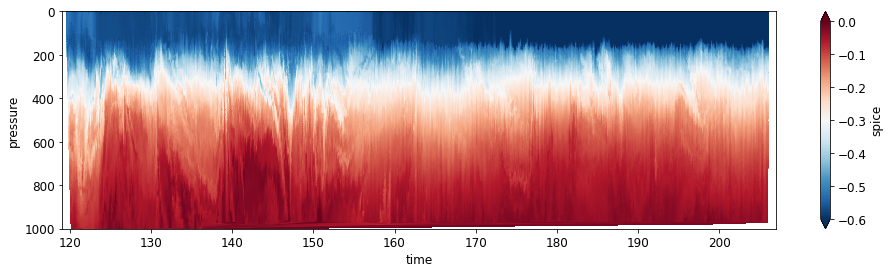

In [33]:
plt.figure(figsize=(16,4))

ds_659_grid_zt.spice.plot(vmin=-0.6, vmax=0, cmap='RdBu_r')
plt.gca().invert_yaxis()

Smooth some in depth (remove any overturns) and time (remove waves)

In [131]:
ds_659_grid_zt_smooth = (ds_659_grid_zt.rolling(pressure=15, center=True).mean()).rolling(
                    time=100, center=True).mean()
ds_660_grid_zt_smooth = (ds_660_grid_zt.rolling(pressure=15, center=True).mean()).rolling(
                    time=100, center=True).mean()

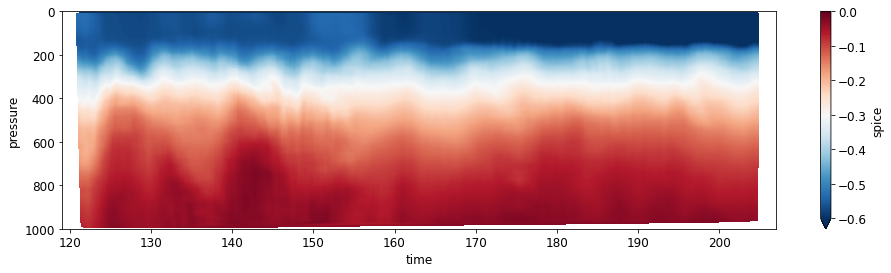

In [132]:
plt.figure(figsize=(16,4))

ds_659_grid_zt_smooth.spice.plot(vmin=-0.6, vmax=0, cmap='RdBu_r')
plt.gca().invert_yaxis()

(120.0, 150.0)

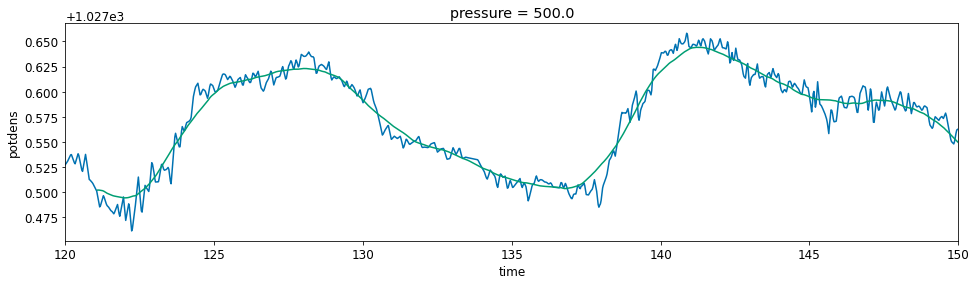

In [133]:
plt.figure(figsize=(16,4))

ds_659_grid_zt.potdens.sel(pressure=500, method='nearest').plot()
ds_659_grid_zt_smooth.potdens.sel(pressure=500, method='nearest').plot()
plt.xlim([120, 150])

In [134]:
g=9.81
rho0=1000
ds_659_grid_zt_smooth['buoyancy'] = - g/rho0*ds_659_grid_zt_smooth.potdens
ds_660_grid_zt_smooth['buoyancy'] = - g/rho0*ds_660_grid_zt_smooth.potdens
#b660 = - g/rho0*ds_660_grid.potdens

In [1]:
ds_659_grid_zt_smooth['N2'] = -ds_659_grid_zt_smooth.buoyancy.diff('pressure')/ ds_659_grid_zt_smooth.pressure.diff('pressure')
ds_660_grid_zt_smooth['N2'] = -ds_660_grid_zt_smooth.buoyancy.diff('pressure')/ ds_660_grid_zt_smooth.pressure.diff('pressure')

NameError: name 'ds_659_grid_zt_smooth' is not defined

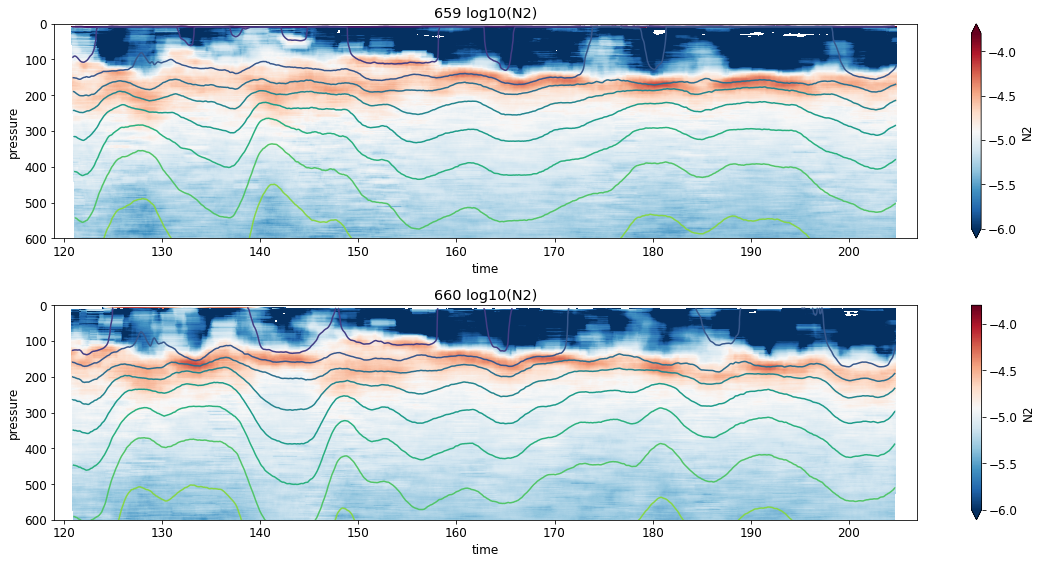

In [136]:
plt.figure(figsize=(16,8))

plt.subplot(211)
np.log10(ds_659_grid_zt_smooth.N2).plot(vmin=-6, vmax=-3.8, cmap='RdBu_r')
ds_659_grid_zt_smooth.potdens.plot.contour(levels=np.linspace(1026.8, 1027.8,12))
plt.gca().invert_yaxis()
plt.ylim([600,0])
plt.title('659 log10(N2)')

plt.subplot(212)
np.log10(ds_660_grid_zt_smooth.N2).plot(vmin=-6, vmax=-3.8, cmap='RdBu_r')
ds_660_grid_zt_smooth.potdens.plot.contour(levels=np.linspace(1026.8, 1027.8,12))
plt.gca().invert_yaxis()
plt.ylim([600,0])
plt.title('660 log10(N2)')

plt.tight_layout()

In [75]:
f = 1.146e-4

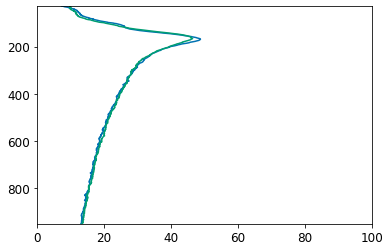

In [137]:
plt.plot(ds_659_grid_zt_smooth.N2.mean('time')**0.5/f, ds_659_grid_zt_smooth.pressure)
plt.plot(ds_660_grid_zt_smooth.N2.mean('time')**0.5/f, ds_660_grid_zt_smooth.pressure)

plt.xlim([0,100])
plt.ylim([30 , 950])

plt.gca().invert_yaxis()

In [138]:
dXdist659 = gt.utils.distance(ds_659_grid_zt_smooth.longitude.mean('pressure'), 
                              ds_659_grid_zt_smooth.latitude.mean('pressure'))
dXdist660 = gt.utils.distance(ds_660_grid_zt_smooth.longitude.mean('pressure'), 
                              ds_660_grid_zt_smooth.latitude.mean('pressure'))

In [139]:
dXdist659.shape

(3520,)

In [140]:
ds_659_grid_zt_smooth['dspicedx'] = ds_659_grid_zt_smooth.spice.diff('time') / dXdist659[1:]
ds_660_grid_zt_smooth['dspicedx'] = ds_660_grid_zt_smooth.spice.diff('time') / dXdist660[1:]

In [141]:
ds_659_grid_zt_smooth['dspice_anom_dx'] = (ds_659_grid_zt_smooth.spice - ds_659_grid_zt_smooth.spice.mean('time')
                                     ).diff('time') / dXdist659[1:]
ds_660_grid_zt_smooth['dspice_anom_dx'] = (ds_660_grid_zt_smooth.spice - ds_660_grid_zt_smooth.spice.mean('time')
                                     ).diff('time') / dXdist660[1:]

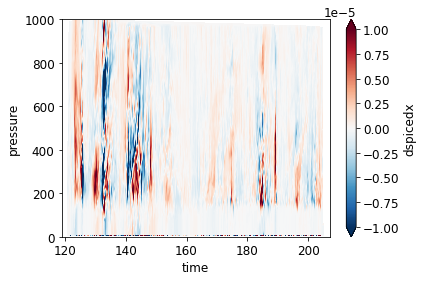

In [142]:
ds_659_grid_zt_smooth.dspicedx.plot(vmin=-1e-5)

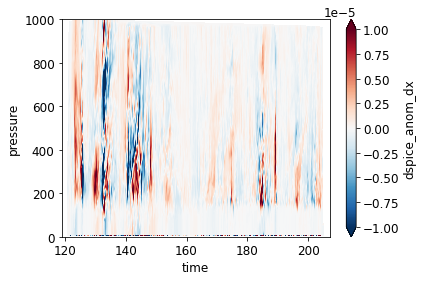

In [143]:
ds_659_grid_zt_smooth.dspice_anom_dx.plot(vmin=-1e-5)

In [144]:
ds_659_grid_zt_smooth['dspicedz'] = -ds_659_grid_zt_smooth.spice.diff('pressure')/ ds_659_grid_zt_smooth.pressure.diff('pressure')
ds_660_grid_zt_smooth['dspicedz'] = -ds_660_grid_zt_smooth.spice.diff('pressure')/ ds_660_grid_zt_smooth.pressure.diff('pressure')

In [145]:
ds_659_grid_zt_smooth['dspice_anom_dz'] = -(ds_659_grid_zt_smooth.spice - ds_659_grid_zt_smooth.spice.mean('time')
                                           ).diff('pressure')/ ds_659_grid_zt_smooth.pressure.diff('pressure')
ds_660_grid_zt_smooth['dspice_anom_dz'] = -(ds_660_grid_zt_smooth.spice - ds_660_grid_zt_smooth.spice.mean('time')
                                           ).diff('pressure')/ ds_660_grid_zt_smooth.pressure.diff('pressure')

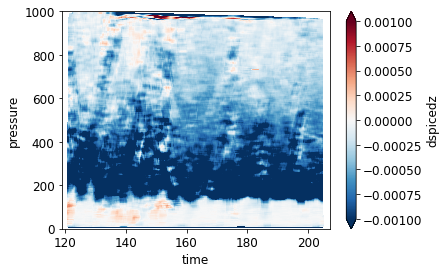

In [146]:
ds_659_grid_zt_smooth.dspicedz.plot(vmin=-1e-3)

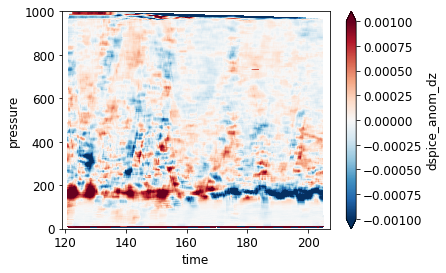

In [147]:
ds_659_grid_zt_smooth.dspice_anom_dz.plot(vmin=-1e-3)

In [148]:
ds_659_grid_zt_smooth.dspice_anom_dz

<xarray.DataArray 'dspice_anom_dz' (pressure: 1001, time: 3520)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * pressure  (pressure) float64 0.0 1.0 2.0 3.0 4.0 ... 997.0 998.0 999.0 1e+03
  * time      (time) float64 119.0 119.0 119.1 119.1 ... 206.9 206.9 207.0 207.0

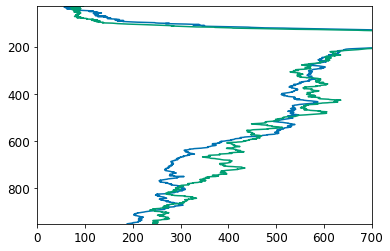

In [149]:
plt.plot( np.abs(ds_659_grid_zt_smooth.dspicedz).mean('time')/
          np.abs(ds_659_grid_zt_smooth.dspicedx).mean('time'), 
         ds_659_grid_zt_smooth.pressure)
plt.plot( np.abs(ds_660_grid_zt_smooth.dspicedz).mean('time')/
          np.abs(ds_660_grid_zt_smooth.dspicedx).mean('time'), 
         ds_660_grid_zt_smooth.pressure)

plt.xlim([0,700])
plt.ylim([30 , 950])

plt.gca().invert_yaxis()

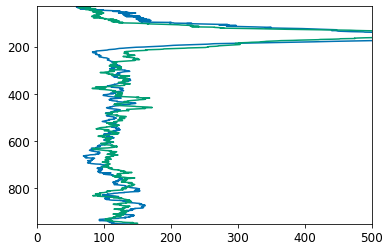

In [150]:
plt.plot( np.abs(ds_659_grid_zt_smooth.dspice_anom_dz).mean('time')/
          np.abs(ds_659_grid_zt_smooth.dspice_anom_dx).mean('time'), 
         ds_659_grid_zt_smooth.pressure)
plt.plot( np.abs(ds_660_grid_zt_smooth.dspice_anom_dz).mean('time')/
          np.abs(ds_660_grid_zt_smooth.dspice_anom_dx).mean('time'), 
         ds_660_grid_zt_smooth.pressure)

plt.xlim([0,500])
plt.ylim([30 , 950])

plt.gca().invert_yaxis()

(array([ 85., 176., 138., 309., 353., 256., 333., 336., 211., 208., 141.,
        132., 145., 111., 110., 123., 107.,  22.,   8.,   4.,   5.,   4.,
          5.,   8.,   7.,  10.,  13.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.]),
 array([   0.        ,   51.28205128,  102.56410256,  153.84615385,
         205.12820513,  256.41025641,  307.69230769,  358.97435897,
         410.25641026,  461.53846154,  512.82051282,  564.1025641 ,
         615.38461538,  666.66666667,  717.94871795,  769.23076923,
         820.51282051,  871.79487179,  923.07692308,  974.35897436,
        1025.64102564, 1076.92307692, 1128.20512821, 1179.48717949,
        1230.76923077, 1282.05128205, 1333.33333333, 1384.61538462,
        1435.8974359 , 1487.17948718, 1538.46153846, 1589.74358974,
        1641.02564103, 1692.30769231, 1743.58974359, 1794.87179487,
        1846.15384615, 1897.43589744, 1948.71794872, 2000.        ]),
 <BarContainer object of 39 artists>)

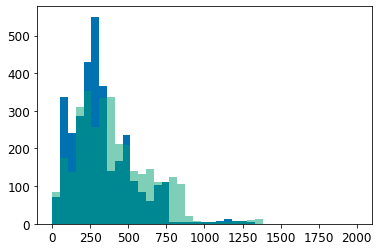

In [151]:
plt.hist(dXdist659, bins = np.linspace(0,2e3,40))
plt.hist(dXdist660, bins = np.linspace(0,2e3,40), alpha = 0.5)

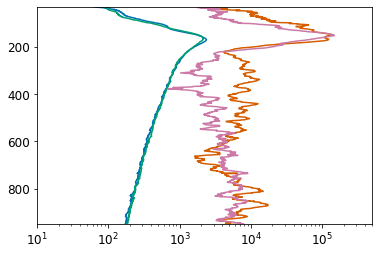

In [155]:
plt.plot(ds_659_grid_zt_smooth.N2.mean('time')/f**2, ds_659_grid_zt_smooth.pressure)
plt.plot(ds_660_grid_zt_smooth.N2.mean('time')/f**2, ds_660_grid_zt_smooth.pressure)

plt.plot( np.abs(ds_659_grid_zt_smooth.dspice_anom_dz**2).mean('time')/
          np.abs(ds_659_grid_zt_smooth.dspice_anom_dx**2).mean('time'), 
         ds_659_grid_zt_smooth.pressure)
plt.plot( np.abs(ds_660_grid_zt_smooth.dspice_anom_dz**2).mean('time')/
          np.abs(ds_660_grid_zt_smooth.dspice_anom_dx**2).mean('time'), 
         ds_660_grid_zt_smooth.pressure)

plt.xlim([10,5e5])
plt.xscale('log')
plt.ylim([30 , 950])

plt.gca().invert_yaxis()

### Using the method that we used before
Which gave acceptable looking result, but now seems that there was some mistake. 

In [154]:
dXdist = gt.utils.distance(ds_660_grid_zt.longitude.mean('pressure'), 
                           ds_660_grid_zt.latitude.mean('pressure'))

In [ ]:
dspice_dx = ds_660_grid.spice_anomaly_filt.rolling(pressure=15,center=True).mean().diff('time')/dXdist[1:]
dspice_dz = ds_660_grid.spice_anomaly_filt.rolling(pressure=15,center=True).mean().diff('pressure')/ds_660_grid.pressure.diff('pressure')